# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [1]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    return (f(x+h)-f(x-h))/(2*h)

#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [2]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))

0.010000 --  0.0001
0.001000 --   1e-06
0.000100 --   1e-08
0.000010 --   1e-10


Значение стремится к нулю, ошибка h^2, все хорошо

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [4]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

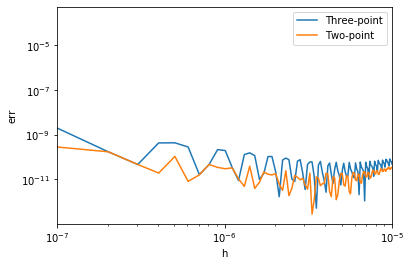

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def up_deriv(f, x, h):
    return (-1.5 * f(x) + 2 * f(x + h) - 0.5 * f(x + 2*h))/h

h = np.linspace(1e-12, 1e-5, 100)

err_two = [np.abs(deriv(f, 1, i) - fder(1)) for i in h]
err_three = [np.abs(up_deriv(f, 1, i) - fder(1)) for i in h]

plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('err')

plt.plot(h, err_three, label='Three-point')
plt.plot(h, err_two, label='Two-point')
plt.xlim([1e-7, 1e-5])
plt.legend()
plt.show()

#####  для двухточечной и трехточечной h~ 5e-6, причем точность немного лучше для двухточечной

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [10]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = up_deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05


##### Все дело в старших производных. Третья производная обратно пропорциональна х, сходимость становится как h

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [24]:
def midpoint_rule(func, a, b, eps):
    """ Calculate the integral of f from a to b using the midpoint rule.
    
    Parameters
    ----------
    func : callable
        The function to integrate.
    a : float
        The lower limit of integration.
    b : float
        The upper limit of integration.
    eps : float
        The target accuracy of the estimate.
        
    Returns
    -------
    integral : float
        The estimate of $\int_a^b f(x) dx$.
    """
    N = 100
    step_n = (b - a) / N
    step_2n = (b - a) / (2*N)
    I_n = 0
    I_2n = 0
    for i in range(N):
        I_n += func(a + step_n/2 + step_n * i) * step_n 
    for i in range(2 * N):
        I_2n += func(a + step_2n/2 + step_2n * i) * step_2n
    while np.abs(I_2n - I_n) > eps: 
        I_n = I_2n
        step_2n /= 2
        I_2n = 0
        N *= 2
        
        for i in range(2 * N):
            I_2n += func(a + step_2n/2 + step_2n * i) * step_2n
        
    return I_n, N  

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


$$
\int_0^4\! x^3\, dx = 64
$$

In [25]:
a, b = midpoint_rule(lambda x: x**3, 0, 4, 1e-6)
print('Ошибка: {}'.format(np.abs(a - 64)))

Ошибка: 7.81250001580247e-07


### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [29]:
eps = 1e-4
a, b = midpoint_rule(lambda x: np.sin(np.sqrt(x))/ x, 0, 1, eps)
print(a, b)

1.8918319782852722 3276800


In [43]:
def wout_sing(x):
    return np.sin(np.sqrt(x))/x - 1/np.sqrt(x)

In [46]:
without_sing, n = midpoint_rule(wout_sing, 0, 1, eps)
# интеграл от 1/sqrt(x) равен 2
I = without_sing + 2
print(I, n)

1.8921562911949747 100


#### С вычитанием сингулярности требуется гораздо меньше итераций